--- INITIALIZING TACTICAL SIMULATION ---
🔥 IGNITION DETECTED at 19.0217, -104.3345
   - Active Front Spread: 8.89 m/min
--- CALCULATING CONTAINMENT LINES ---
--- GENERATING TACTICAL MAP ---


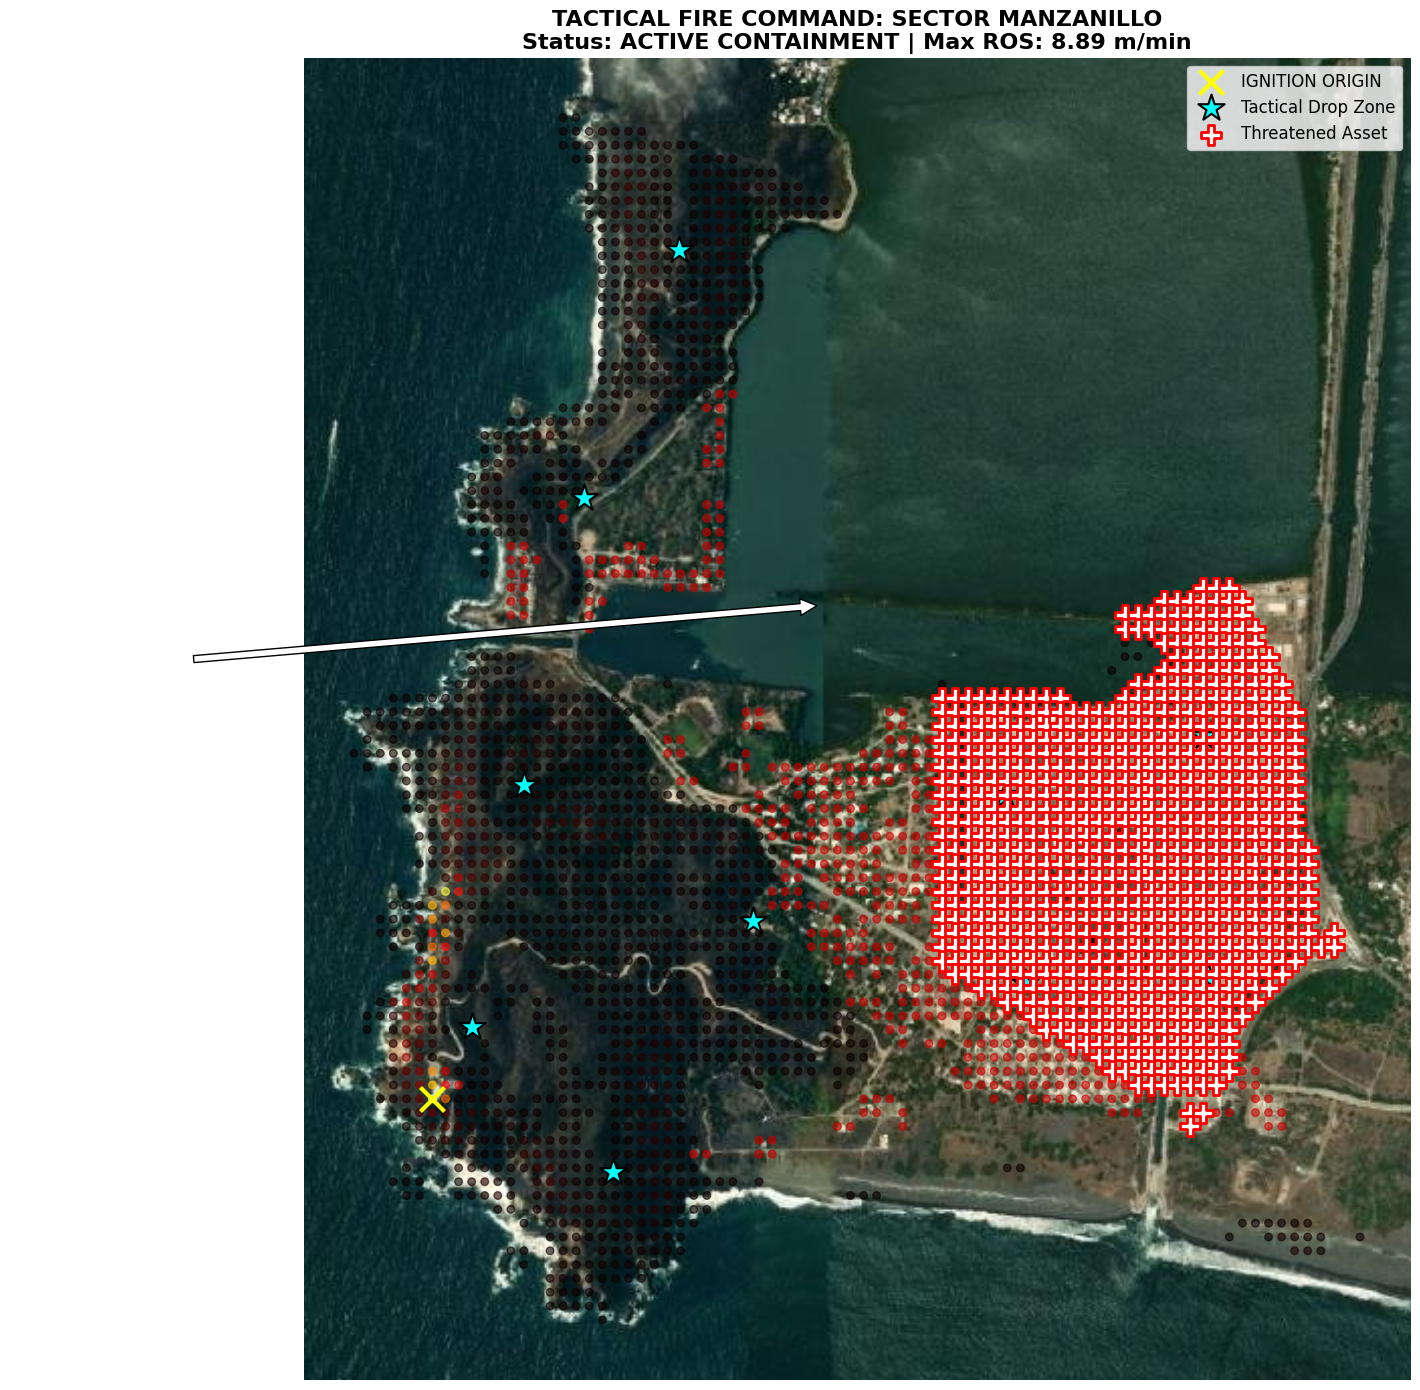

In [1]:
# =============================================================================
# 09_Fire_Spread_Simulation.ipynb - COMMANDER'S VIEW (Final Fix)
# OBJECTIVE: clear tactical map showing Ignition -> Vector -> Containment.
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import geopandas as gpd
from shapely.geometry import Point, LineString
import contextily as ctx
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
import os
import warnings

warnings.filterwarnings("ignore")

# --- 1. CONFIGURATION ---
PORT_LAT = 19.052
PORT_LON = -104.315
VIS_CRS = "EPSG:3857"
NUM_ATTACK_ZONES = 10  # Focused number of drop zones
RANDOM_STATE = 42

BASE_DIR = '../' if os.path.exists('../data') else ''
MASTER_DATA_PATH = BASE_DIR + 'data/processed/manzanillo_MASTER_TWIN_DATA.csv'
SENSORS_PATH = BASE_DIR + 'data/processed/optimized_sensor_network.csv'

# --- 2. DATA & PHYSICS (Standard Setup) ---
def get_live_weather(lat, lon):
    try:
        url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current=wind_speed_10m,wind_direction_10m&wind_speed_unit=kmh"
        response = requests.get(url, timeout=2)
        data = response.json()['current']
        return data['wind_speed_10m'], data['wind_direction_10m']
    except:
        return 15.0, 225.0

def rothermel_predict(row, wind_speed):
    slope_deg = row['slope']
    if row['fuel_model'] == 'Industrial_Port': I_r = 10000
    elif row['fuel_model'] == 'Urban_WUI': I_r = 7000
    else: I_r = 1500
    phi_s = 5.275 * (np.tan(np.radians(slope_deg)))**2
    phi_w = 0.74 * (wind_speed ** 0.8)
    heat_sink = 8000
    return (I_r * (1 + phi_w + phi_s)) / heat_sink

print("--- INITIALIZING TACTICAL SIMULATION ---")
try:
    master_twin = pd.read_csv(MASTER_DATA_PATH)
    sensors = pd.read_csv(SENSORS_PATH)
    live_speed, live_dir = get_live_weather(PORT_LAT, PORT_LON)
    
    # Run Physics
    master_twin['ros_predicted'] = master_twin.apply(lambda row: rothermel_predict(row, live_speed), axis=1)
    
    # --- CRITICAL FIX: LOCALIZE THE THREAT ---
    # Instead of showing high ROS everywhere, we define an IGNITION POINT
    # and only show threat zones within a realistic radius (e.g., 2km)
    ignition_idx = master_twin['ros_predicted'].idxmax()
    ig_lat, ig_lon = master_twin.loc[ignition_idx, ['latitude', 'longitude']]
    
    # Filter for proximity to ignition (The Active Fire)
    master_twin['dist_to_ig'] = np.sqrt((master_twin['latitude']-ig_lat)**2 + (master_twin['longitude']-ig_lon)**2)
    active_fire_zone = master_twin[master_twin['dist_to_ig'] < 0.02].copy() # Approx 2km radius
    
    max_ros = active_fire_zone['ros_predicted'].max()
    print(f"🔥 IGNITION DETECTED at {ig_lat:.4f}, {ig_lon:.4f}")
    print(f"   - Active Front Spread: {max_ros:.2f} m/min")

except FileNotFoundError:
    print("❌ ERROR: Data missing.")
    raise

# --- 3. TACTICAL DEPLOYMENT CALCULATION ---
print("--- CALCULATING CONTAINMENT LINES ---")

# A. Identify Threat WITHIN the active zone
threat_threshold = active_fire_zone['ros_predicted'].quantile(0.85)
threat_cells = active_fire_zone[active_fire_zone['ros_predicted'] >= threat_threshold].copy()

# B. Prioritize Defense (Assets near the fire)
nearby_assets = active_fire_zone[active_fire_zone['priority_boost'] > 1.0]
deploy_data = pd.concat([threat_cells, nearby_assets], ignore_index=True)

# C. Cluster Drop Zones
kmeans = KMeans(n_clusters=NUM_ATTACK_ZONES, random_state=RANDOM_STATE, n_init=10)
kmeans.fit(deploy_data[['latitude', 'longitude']])
drop_zones = pd.DataFrame(kmeans.cluster_centers_, columns=['latitude', 'longitude'])
drop_zones['type'] = 'Air Drop / Firebreak'

# --- 4. COMMAND DASHBOARD (VISUALIZATION) ---
print("--- GENERATING TACTICAL MAP ---")

# Projections
gdf_fire = gpd.GeoDataFrame(active_fire_zone, geometry=gpd.points_from_xy(active_fire_zone.longitude, active_fire_zone.latitude), crs="EPSG:4326").to_crs(VIS_CRS)
gdf_drops = gpd.GeoDataFrame(drop_zones, geometry=gpd.points_from_xy(drop_zones.longitude, drop_zones.latitude), crs="EPSG:4326").to_crs(VIS_CRS)
gdf_assets = gpd.GeoDataFrame(nearby_assets, geometry=gpd.points_from_xy(nearby_assets.longitude, nearby_assets.latitude), crs="EPSG:4326").to_crs(VIS_CRS)

# Ignition Point
gdf_ig = gpd.GeoDataFrame({'geometry': [Point(ig_lon, ig_lat)]}, crs="EPSG:4326").to_crs(VIS_CRS)

fig, ax = plt.subplots(figsize=(14, 14))

# 1. Plot the Fire Front (Heatmap)
gdf_fire[gdf_fire['ros_predicted'] >= threat_threshold].plot(
    ax=ax, column='ros_predicted', cmap='hot', markersize=30, alpha=0.6, zorder=2
)

# 2. Plot Ignition (The Origin)
gdf_ig.plot(ax=ax, marker='x', color='yellow', markersize=300, linewidth=3, zorder=10, label='IGNITION ORIGIN')

# 3. Plot Drop Zones (The Defense Line)
gdf_drops.plot(ax=ax, marker='*', color='cyan', markersize=400, edgecolor='black', linewidth=1.5, zorder=5, label='Tactical Drop Zone')

# 4. Plot Threatened Assets (The Objective)
if not gdf_assets.empty:
    gdf_assets.plot(ax=ax, marker='P', color='white', markersize=200, edgecolor='red', linewidth=2, zorder=6, label='Threatened Asset')

# 5. Add Wind Vector (The Driver)
# Draw an arrow indicating wind direction
# Wind dir is "Coming From". We want arrow pointing "Towards".
wind_rad = np.radians((live_dir + 180) % 360) 
arrow_len = 2000 # Meters
start_x, start_y = gdf_ig.geometry.x.iloc[0] - 1000, gdf_ig.geometry.y.iloc[0] + 1000
end_x = start_x + arrow_len * np.sin(wind_rad)
end_y = start_y + arrow_len * np.cos(wind_rad)

ax.annotate(f"WIND: {live_speed} km/h", xy=(end_x, end_y), xytext=(start_x, start_y),
            arrowprops=dict(facecolor='white', shrink=0.05, edgecolor='black', width=5),
            fontsize=12, fontweight='bold', color='white', zorder=20)

# 6. Basemap
try:
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, attribution=False)
except:
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, attribution=False)

# Legend & Title
ax.set_title(f"TACTICAL FIRE COMMAND: SECTOR MANZANILLO\nStatus: ACTIVE CONTAINMENT | Max ROS: {max_ros:.2f} m/min", fontsize=16, fontweight='bold', color='black')
ax.legend(loc='upper right', fontsize=12)
ax.set_axis_off()

plt.tight_layout()
plt.show()